Importação do otimizador Adam para ajuste de pesos durante o treinamento da rede neural, funcionalidade RandomSearch do Keras Tuner para sintonizar hiperparâmetros e encontrar configurações otimizadas do modelo. Divisão dos dados em conjuntos de treinamento e teste usando a função train_test_split do scikit-learn. Normalização dos dados para garantir que todas as features tenham a mesma escala usando MinMaxScaler do scikit-learn.

In [54]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras_tuner import HyperParameters

In [55]:
# Carregando os dados e pré-processando
import chardet
with open('Clean_Dataset.csv', 'rb') as file:
    result = chardet.detect(file.read())
    encoding = result['encoding']

data = pd.read_csv('Clean_Dataset.csv', encoding=encoding)

In [56]:
data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [58]:
data.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [59]:
# Lista com os nomes das colunas a serem excluídas,
colunas_a_excluir = ['Unnamed: 0']
# Excluindo as colunas
data = data.drop(columns=colunas_a_excluir)

In [60]:
data.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [61]:
# Contar valores vazios (NaN) em cada coluna
valores_vazios = data.isna().sum()

# Imprimir a contagem de valores vazios para cada coluna
print(valores_vazios)


airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64


In [64]:
# Remover colunas não numéricas
data_numeric = data.select_dtypes(include=[np.number])

In [66]:
#Calcular a correlação
pearson = data_numeric.corr(method='pearson')
spearman = data_numeric.corr(method='spearman')


In [67]:
# Criando a máscaras para os Heatmapa da correlações
mask_pearson = np.triu(np.ones_like(pearson, dtype=bool))
mask_spearman = np.triu(np.ones_like(spearman, dtype=bool))

C:\Users\as_pc\AppData\Local\Temp\ipykernel_18328\831830729.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


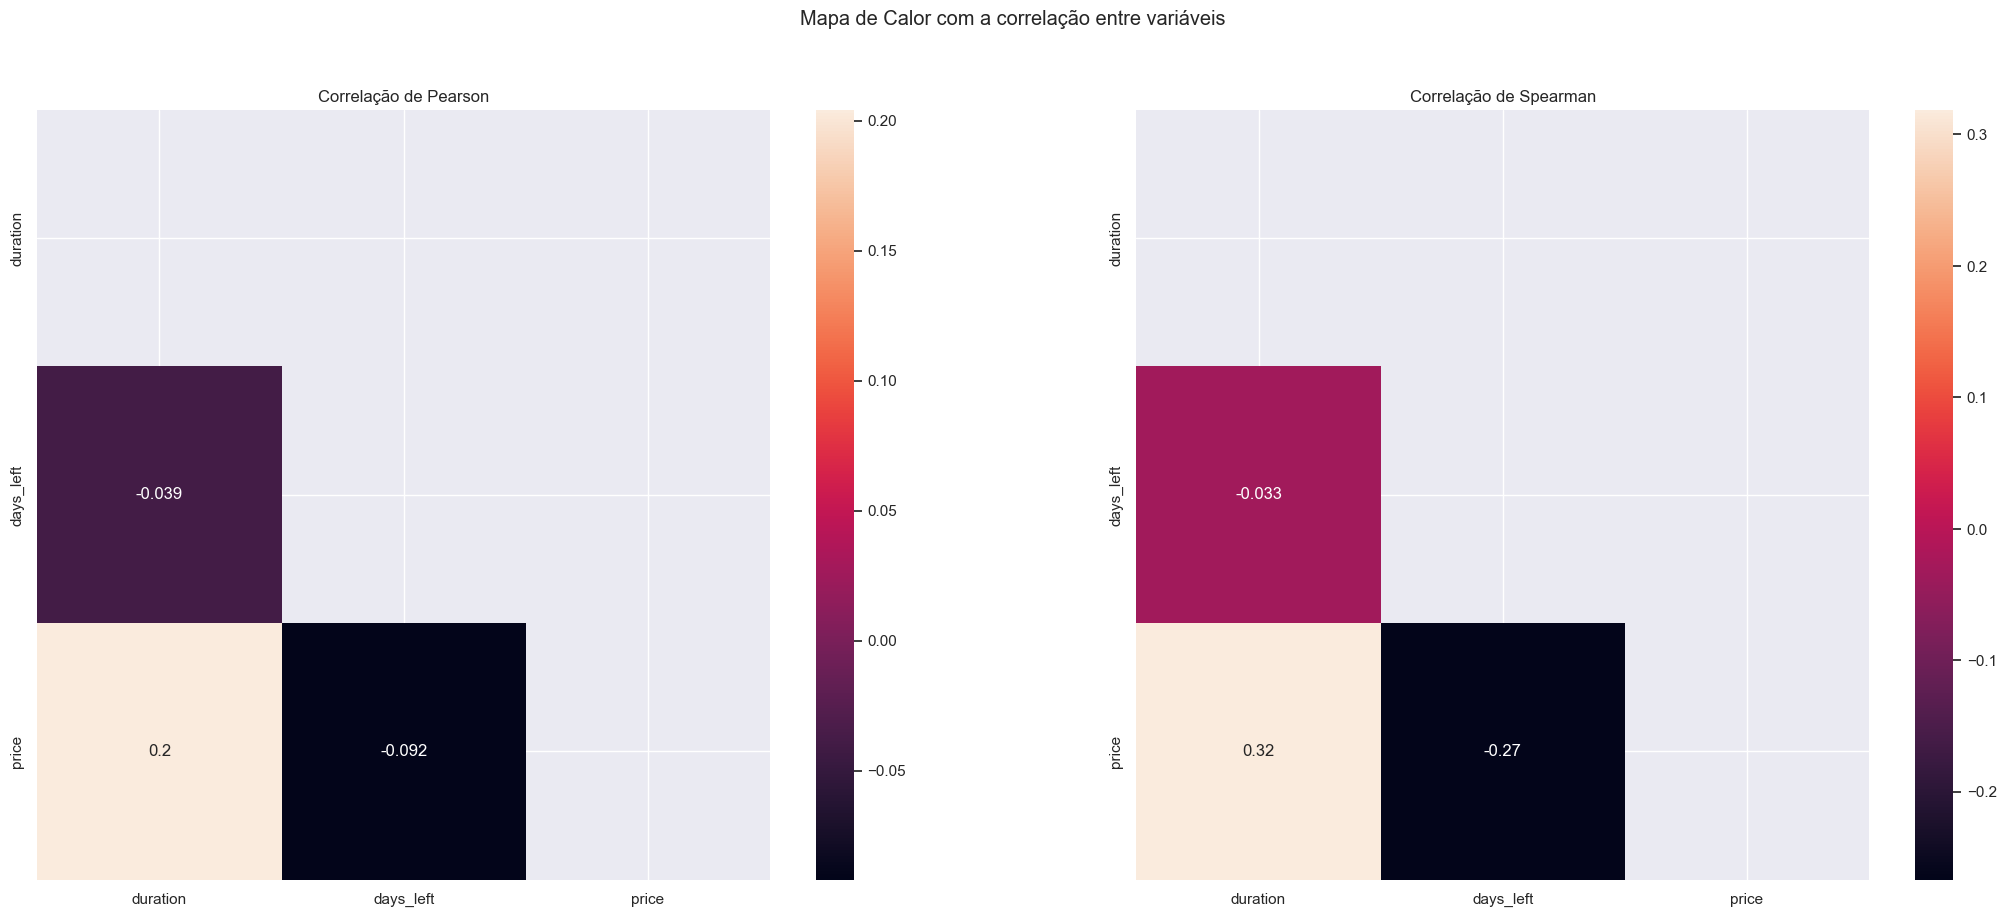

In [68]:
# Imprimindo o heatmap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1, 2, figsize=(26, 10))
sns.heatmap(data=pearson, annot=True, mask=mask_pearson, ax=ax[0])
ax[0].set_title("Correlação de Pearson")
sns.heatmap(data=spearman, annot=True, mask=mask_spearman, ax=ax[1])
ax[1].set_title("Correlação de Spearman")
fig.suptitle('Mapa de Calor com a correlação entre variáveis')
fig.show()

In [69]:
datadum = pd.get_dummies(data)

# Converter variáveis categóricas em numéricas (one-hot encoding)
data_encoded = pd.get_dummies(data)

In [70]:
# Separando os previsores das classes
datadum = pd.get_dummies(data)
scaler_X = MinMaxScaler()
datadum = pd.DataFrame(scaler_X.fit_transform(datadum))
prev = datadum.iloc[:, :-1].values
classe = datadum.iloc[:, -1].values.reshape(-1, 1)


In [71]:
datadum.describe()

,0,1,2,3,4,5,6,7,8,9,...,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598
count,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,...,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000
mean,0.232470,0.520932,0.162215,0.053633,0.269503,0.077204,0.143660,0.030021,0.425979,0.000130,...,0.209010,0.304971,0.170140,0.134491,0.191103,0.142347,0.165029,0.196890,0.311464,0.688536
std,0.146775,0.282521,0.186099,0.225292,0.443702,0.266915,0.350745,0.170646,0.494491,0.011398,...,0.406602,0.460396,0.375756,0.341180,0.393170,0.349407,0.371207,0.397649,0.463093,0.463093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.122449,0.291667,0.030156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.212653,0.520833,0.051818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.313061,0.770833,0.339570,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
# Dividindo os dados em treino, validação e teste
train_x, test_valid_x, train_y, test_valid_y = train_test_split(prev, classe, test_size=0.25, random_state=0)
test_x, valid_x, test_y, valid_y = train_test_split(test_valid_x, test_valid_y, test_size=0.25, random_state=0)

In [73]:
def build_model_wrapper(hp):
    model = Sequential()

    # Camada de entrada
    model.add(Dense(units=hp.Int('units_input', min_value=8, max_value=512, step=8),
                    activation=hp.Choice('activation_input', values=['relu', 'tanh']),
                    kernel_initializer='he_uniform',
                    input_dim=train_x.shape[1]))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.2, max_value=0.3, step=0.1)))

    # Camadas ocultas
    for i in range(hp.Int('num_layers', min_value=1, max_value=8)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=8, max_value=512, step=8),
                        activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh']),
                        kernel_initializer='he_uniform',
                        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.3, step=0.1)))

    # Camada de saída
    model.add(Dense(1, activation='linear'))

    # Compilando o modelo
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    if optimizer == 'adam':
        model.compile(
            optimizer=Adam(learning_rate),
            loss='mape',
            metrics=['mae']
        )
    elif optimizer == 'sgd':
        model.compile(
            optimizer=SGD(learning_rate),
            loss='mape',
            metrics=['mae']
        )
    else:
        raise ValueError(f"Otimizador não suportado: {optimizer}")

    return model



import numpy as np

def maybe_compute_model_size(model):
    try:
        return np.prod([np.prod(p.shape) for p in model.trainable_weights])
    except Exception as e:
        raise RuntimeError("Erro ao calcular o tamanho do modelo: {}".format(e))


In [74]:
# Criando o tuner
tuner = RandomSearch(
    build_model_wrapper,
    objective='val_mae',
    max_trials=10,
    seed=42,
    directory='flight_data2',
    project_name='flight_price'
)

In [75]:
# Realizando a busca de hiperparâmetros
tuner.search(train_x, train_y, epochs=10, validation_data=(valid_x, valid_y))

Trial 10 Complete [00h 05m 40s]
val_mae: 905470.5

Best val_mae So Far: 0.4683551490306854
Total elapsed time: 01h 00m 51s


In [76]:
# Obtendo os melhores hiperparâmetros e a melhor precisão
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_precision = tuner.oracle.get_best_trials(num_trials=1)[0].score

In [77]:
# Imprimindo os melhores parâmetros e a melhor precisão
print("Melhores Parâmetros:", best_hps.values)
print("Melhor Precisão:", best_precision)

Melhores Parâmetros: {'units_input': 328, 'activation_input': 'relu', 'dropout_input': 0.2, 'num_layers': 3, 'units_0': 456, 'activation_0': 'relu', 'dropout_0': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0001, 'units_1': 8, 'activation_1': 'relu', 'dropout_1': 0.2, 'units_2': 8, 'activation_2': 'relu', 'dropout_2': 0.2}
Melhor Precisão: 0.4683551490306854


In [78]:
# Criando o modelo com os melhores hiperparâmetros usando a função wrapper
model = build_model_wrapper(best_hps)

In [79]:
# Treinando o modelo
history = model.fit(train_x, train_y, epochs=50, validation_data=(valid_x, valid_y))

Epoch 1/50
7035/7035 [==============================] - 44s 6ms/step - loss: 56125.9375 - mae: 0.5754 - val_loss: 315.0061 - val_mae: 0.4669
Epoch 2/50
7035/7035 [==============================] - 42s 6ms/step - loss: 4772.8667 - mae: 0.4935 - val_loss: 1883.4198 - val_mae: 0.4550
Epoch 3/50
7035/7035 [==============================] - 42s 6ms/step - loss: 4676.9229 - mae: 0.4858 - val_loss: 4037.3679 - val_mae: 0.4567
Epoch 4/50
7035/7035 [==============================] - 41s 6ms/step - loss: 4842.0220 - mae: 0.4719 - val_loss: 617.1572 - val_mae: 0.4704
Epoch 5/50
7035/7035 [==============================] - 42s 6ms/step - loss: 12967.2930 - mae: 0.4484 - val_loss: 2635.9700 - val_mae: 0.4950
Epoch 6/50
7035/7035 [==============================] - 42s 6ms/step - loss: 5622.2407 - mae: 0.4548 - val_loss: 6413.5815 - val_mae: 0.5035
Epoch 7/50
7035/7035 [==============================] - 42s 6ms/step - loss: 10414.5312 - mae: 0.4526 - val_loss: 12466.0605 - val_mae: 0.4815
Epoch 8/50


In [80]:
# Obtendo a precisão do modelo no conjunto de validação
val_mape = history.history['val_loss'][-1]
val_mae = history.history['val_mae'][-1]

In [81]:
# Imprimindo as métricas
print(f"MAPE no conjunto de validação: {val_mape}")
print(f"MAE no conjunto de validação: {val_mae}")

MAPE no conjunto de validação: 4601.5595703125
MAE no conjunto de validação: 0.49913614988327026


In [82]:
title_large = "Análise de Desempenho do Modelo"


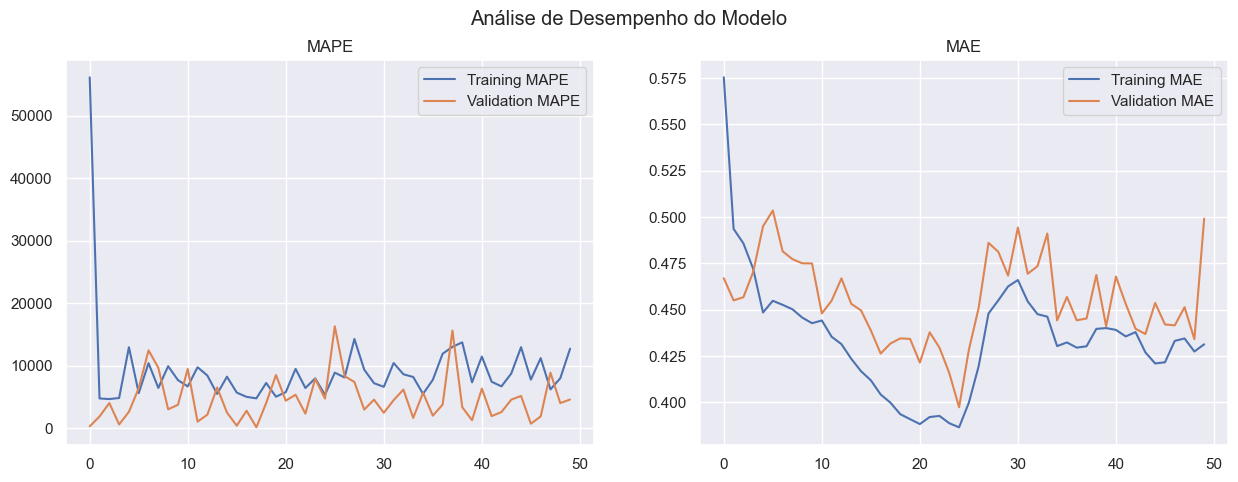

In [83]:
import matplotlib.pyplot as plt

# Função para plotar o histórico de treinamento com MAPE e MAE
def plot_history(history, title):
    # Criando subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plotando MAPE
    axs[0].plot(history.history['loss'], label='Training MAPE')
    axs[0].plot(history.history['val_loss'], label='Validation MAPE')
    axs[0].set_title('MAPE')
    axs[0].legend()

    # Plotando MAE
    axs[1].plot(history.history['mae'], label='Training MAE')
    axs[1].plot(history.history['val_mae'], label='Validation MAE')
    axs[1].set_title('MAE')
    axs[1].legend()

    # Adicionando título geral
    fig.suptitle(title)

    # Exibindo os gráficos
    plt.show()

# Chamando a função para plotar o histórico
plot_history(history, title_large)

In [84]:
from keras.models import model_from_json

# Salvar a estrutura da rede em um arquivo JSON
modelo_json = model.to_json()
with open("estrutura_modelo_tuner.json", "w") as json_file:
    json_file.write(modelo_json)

# Salvar os pesos da rede em um arquivo H5 (como você já estava fazendo)
model.save('modelo_tuner.h5')

C:\Users\as_pc\anaconda3\envs\REGRESS\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
